# Unit 5 - Financial Planning


In [2]:
# Initial imports
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv("./.env")

True

## Part 1 - Personal Finance Planner

In [4]:
# Set monthly household income
monthly_income = 12000

### Collect Crypto Prices Using the `requests` Library

In [5]:
# Current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [6]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [7]:
# Define function to fetch current alternative currency price
def crypto_fetch_resolve(alt_cur_url, id):
    # Format id as int
    id = int(id)
    # Use requests library to grab data about alternative currency
    response = requests.get(alt_cur_url)
    # Grab the content from that response and format as JSON object
    content = response.json()
    return content['data'][f"{id}"]['quotes']['USD']['price']
# Execute function for BTC
crypto_fetch_resolve(eth_url, 1027)

340.73

In [8]:

# Fetch current ETH price
btc_res = crypto_fetch_resolve(btc_url, 1)
eth_res = crypto_fetch_resolve(eth_url, 1027)

# Compute current value of my crypto
my_btc_value = my_btc * btc_res
my_eth_value = my_eth * eth_res

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $12571.84
The current value of your 5.3 ETH is $1805.87


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [9]:
# Current amount of shares
my_agg = 200
my_spy = 50

In [10]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')
# print(alpaca_api_key, alpaca_secret_key)

In [33]:
# Format current date as ISO format
current_date = pd.datetime.now()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
closing_prices = alpaca_api.get_barset(
    tickers,
    timeframe,
    limit=1
)

# Pick AGG and SPY close prices
agg_close_price = closing_prices["AGG"][0].c
spy_close_price = closing_prices["SPY"][0].c

# Print AGG and SPY close prices
# print(closing_prices)
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $118.31
Current SPY closing price: $330.33


In [34]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $16516.50
The current value of your 200 AGG shares is $23662.00


### Savings Health Analysis

In [61]:
# Create savings DataFrame
my_savings = pd.DataFrame({"Investment":["BTC", "ETH", "AGG", "SPY"], "Value": [my_btc_value, my_eth_value, my_agg_value, my_spy_value]})

my_savings.set_index('Investment', inplace=True)
# Display savings DataFrame
display(my_savings)

,Value
Investment,
BTC,12571.836
ETH,1805.869
AGG,23662.000
SPY,16516.500


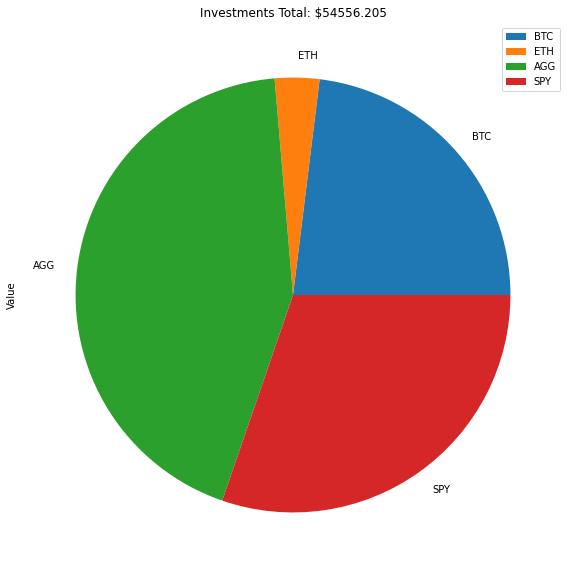

In [83]:
# Plot savings pie chart
my_sav_sum = my_savings["Value"].sum(axis=0)
pie_chart = my_savings.plot.pie(y='Value', figsize=(10,10), title=f"Investments Total: ${my_sav_sum}")

In [95]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
# print(f"Your investment savings total ${my_sav_sum}")

# Validate saving health
def do_i_have_enuff(savings):
    print(f"You make ${monthly_income} per month, and for the sake of emergency, should have at least ${emergency_fund} in savings at all times.")
    if savings >= emergency_fund:
        print(f"With ${savings} saved, you have more than enough for emergencies.")
    else:
        print(f"Save more.")


do_i_have_enuff(my_sav_sum)

You make $12000 per month, and for the sake of emergency, should have at least $36000 in savings at all times.
With $54556.205 saved, you have more than enough for emergencies.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [100]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2015-08-07', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2020-08-07', tz='America/New_York').isoformat()

In [104]:
# Get 5 years' worth of historical data for SPY and AGG
five_years = alpaca_api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

five_years.drop(columns=["open", "low", "high", "volume"], level=1, inplace=True)

# Display sample data
five_years.head()

,AGG,SPY
,close,close
time,,
2015-08-07 00:00:00-04:00,109.21,207.93
2015-08-10 00:00:00-04:00,109.06,210.58
2015-08-11 00:00:00-04:00,109.42,208.63
2015-08-12 00:00:00-04:00,109.36,208.89
2015-08-13 00:00:00-04:00,109.15,208.63


In [114]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
five_yr_daily_returns = five_years.pct_change().dropna()
five_yr_daily_returns.tail(20)

,AGG,SPY
,close,close
time,,
2020-07-13 00:00:00-04:00,0.000084,-0.008816
2020-07-14 00:00:00-04:00,0.001477,0.012960
2020-07-15 00:00:00-04:00,-0.000169,0.009329
2020-07-16 00:00:00-04:00,0.001138,-0.003433
2020-07-17 00:00:00-04:00,0.000758,0.002837
2020-07-20 00:00:00-04:00,0.001010,0.008363
2020-07-21 00:00:00-04:00,0.000588,0.001850
2020-07-22 00:00:00-04:00,0.001092,0.005724


In [ ]:
# Printing the simulation input data
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

### Retirement Analysis

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
print(tbl)

### Given an initial investment of $20,000, what is the expected portfolio return in dollars at the 95% lower and upper confidence intervals?

In [ ]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

### How would a 50% increase in the initial investment amount affect the expected portfolio return in dollars at the 95% lower and upper confidence intervals?

In [ ]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
print(tbl_five)

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

### Ten Years Retirement Option

In [ ]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
print(tbl_ten)

In [ ]:
# Set initial investment
# YOUR CODE HERE!

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# YOUR CODE HERE!

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")